In [1]:
# ADP 23회 ML - 객실사용여부 분류

In [2]:
import os

In [3]:
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/adp23-p1.csv
data/adp23-p2.csv
data/adp23-p3_covid.csv


In [4]:
## EDA

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('data/adp23-p1.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17910 entries, 0 to 17909
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           17910 non-null  object 
 1   Temperature    17910 non-null  float64
 2   Humidity       17910 non-null  float64
 3   Light          17910 non-null  float64
 4   CO2            17889 non-null  float64
 5   HumidityRatio  17910 non-null  float64
 6   Occupancy      17910 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 979.6+ KB


In [8]:
display(df.isnull().sum()) # CO2 컬럼의 결측치 발견

date              0
Temperature       0
Humidity          0
Light             0
CO2              21
HumidityRatio     0
Occupancy         0
dtype: int64

In [9]:
print(df[df.CO2.isnull()].date.values) # 결측치가 발생한 일시의 패턴이 불규칙적

['2015-02-03 19:09:59' '2015-02-03 19:31:00' '2015-02-04 18:08:00'
 '2015-02-05 06:08:00' '2015-02-05 16:09:59' '2015-02-08 08:06:00'
 '2015-02-08 11:54:00' '2015-02-08 20:58:59' '2015-02-09 06:04:59'
 '2015-02-09 07:31:00' '2015-02-09 07:49:00' '2015-02-10 07:53:59'
 '2015-02-12 00:34:00' '2015-02-12 10:53:00' '2015-02-12 15:04:00'
 '2015-02-12 20:38:00' '2015-02-13 22:53:59' '2015-02-15 16:41:59'
 '2015-02-16 00:53:59' '2015-02-17 01:56:00' '2015-02-18 06:20:00']


In [10]:
import seaborn as sns

In [11]:
import matplotlib.pyplot as plt

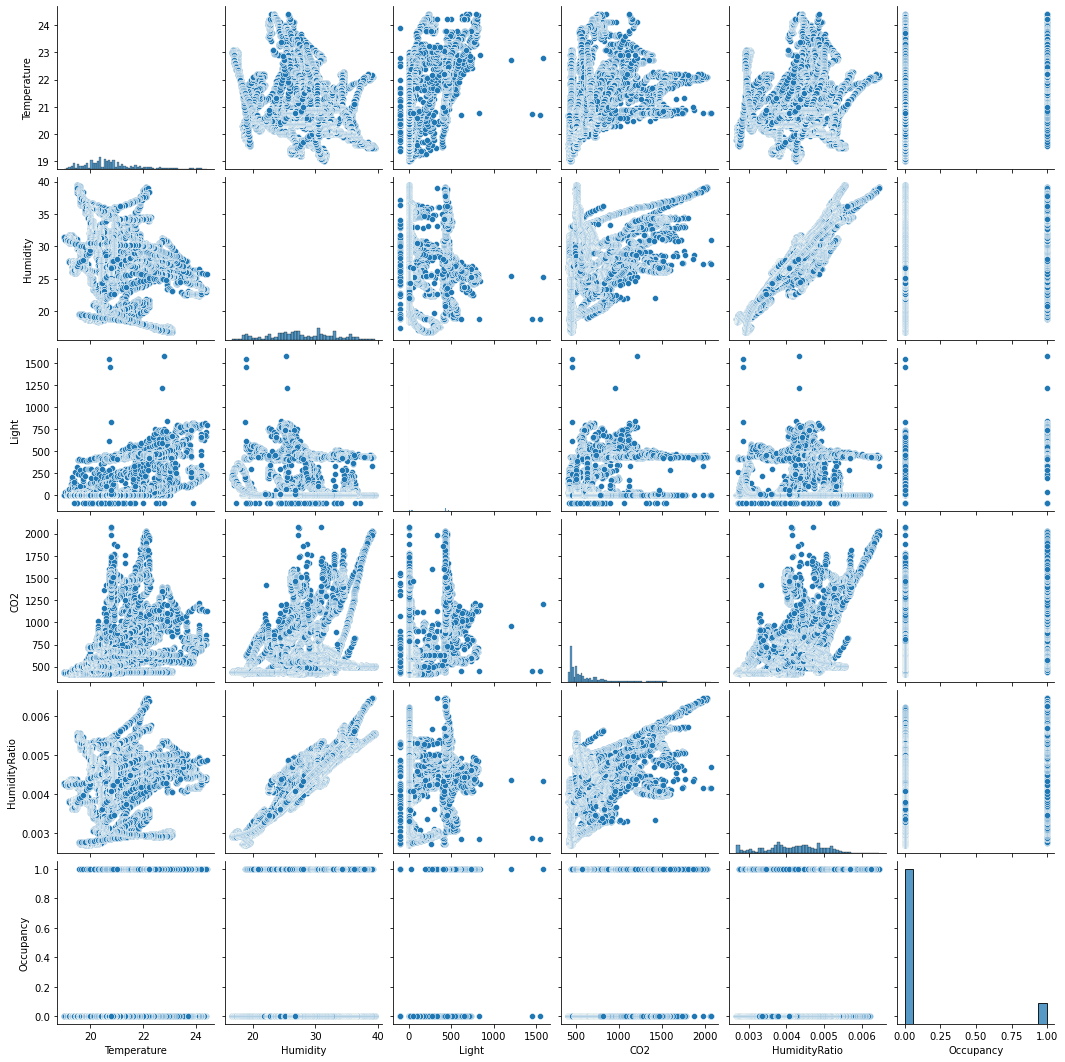

In [12]:
sns.pairplot(df)  # humidity 와 humidityratio 컬럼의 높은 상관관계 발견

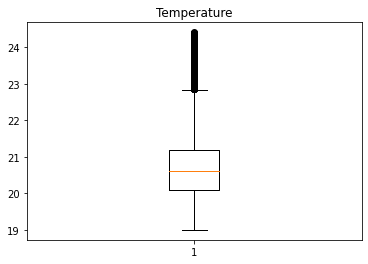

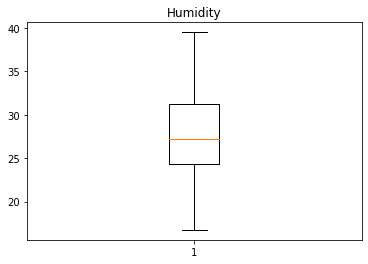

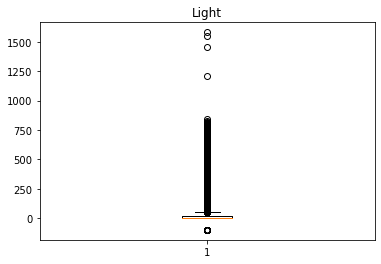

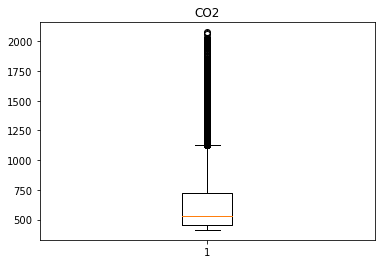

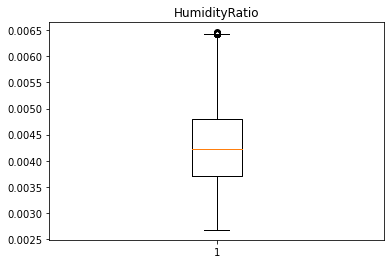

In [13]:
for v in df.select_dtypes(include='float'):
    target = df[v].dropna()
    plt.boxplot(target)
    plt.title(v)
    plt.show()
# temperature, light, CO2 에서 이상치 발견

In [14]:
display(df.describe())

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,17910.000000,17910.000000,17910.000000,17889.000000,17910.000000,17910.000000
mean,20.749036,27.589163,78.157369,647.700865,0.004175,0.117253
std,0.994012,5.043595,168.574068,285.997340,0.000755,0.321730
min,19.000000,16.745000,-99.000000,412.750000,0.002674,0.000000
25%,20.100000,24.390000,0.000000,453.000000,0.003702,0.000000
50%,20.600000,27.200000,0.000000,532.666667,0.004222,0.000000
75%,21.200000,31.290000,22.000000,722.000000,0.004790,0.000000
max,24.408333,39.500000,1581.000000,2076.500000,0.006461,1.000000


In [15]:
display(df[df.Light < 0].shape) # light 컬럼에서 음수인 값 50개 발견

(50, 7)

In [16]:
df['date'] = pd.to_datetime(df['date'])

In [17]:
timedeltas = df['date'].diff().dt.seconds.dropna()

In [18]:
display(timedeltas.describe()) 
# 일시데이터의 75%는 61초이내의 간격으로 존재하고, 최대간격은 25680초 (결측치와의 간격으로 추정)

count    17909.000000
mean        71.357474
std        241.363584
min         59.000000
25%         60.000000
50%         60.000000
75%         61.000000
max      25680.000000
Name: date, dtype: float64

In [19]:
## 결측치 대체 방식을 선택하고 근거 제시 및 수행

In [20]:
# CO2 컬럼에 nan값으로 비어있는 데이터는 직전, 직후 데이터를 비교해서 
# (1) Occupancy값이 변화하지 않거나, 
# (2) date값이 3분이내로 연속하는 데이터라고 한다면 직전 CO2값으로 대체 
# 위의 두 기준에 해당한다면 
# 모든 CO2의 결측치를 대체 할 수 있고 데이터의 품질을 손상 시키지 않다고 판단

In [21]:
for value in df[df.CO2.isnull()].index:
    target = df.iloc[value-1:value+2]
    difftime = target['date'].diff().dt.seconds.dropna()
    if target.Occupancy.nunique() == 1 and len(difftime[difftime>180]) == 0:
        df.loc[value, 'CO2'] = df.loc[value-1].CO2

In [22]:
df.isnull().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

In [23]:
## 추가적으로 데이터의 질 및 품질관리 향상시킬만한 내용

In [24]:
df.loc[df.Light == -99, 'Light'] = 0   # light에서 -99로 입력된 값을 0으로 대체

In [25]:
# date 컬럼에도 결측치가 존재하지만 date를 활용한 시계열분석이 아니므로 결측치 대체하지 않음

In [26]:
## 데이터에 불균형이 있는지 확인, 판단근거 제시

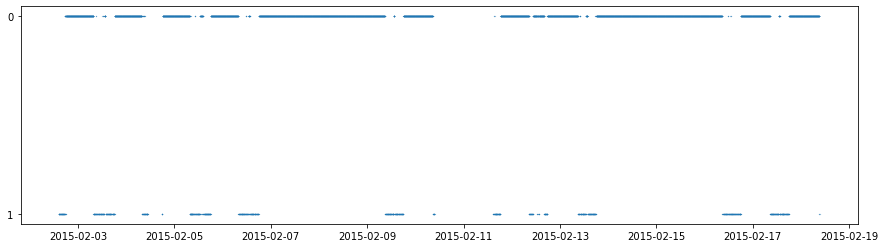

In [78]:
plt.figure(figsize=(15,4))
plt.scatter(df['date'], df['Occupancy'].astype('str'), s=0.03)  
# 객실이 비어있는 경우가 더 많음 -> 불균형

In [29]:
df.Occupancy.value_counts()

0    15810
1     2100
Name: Occupancy, dtype: int64

In [30]:
## 오버샘플링 방법들 중 2개 선택하고 장단점 및 선정 이유 제시

In [31]:
# (1) 랜덤오버샘플링 : 소수 클래스 데이터 중 랜덤 샘플링하여 다수 클래스 데이터 숫자와 맞추는 방식
# 장점 - 데이터 불균형 문제 해결
# 단점 - 종속변수에 대한 고려없이 중복 생성, overfitting 가능성 존재
# (2) SMOTE : 소수 클래스 데이터와 그 데이터에서 가장 가까운 k개의 소수 클래스 데이터 중에서
# 무작위로 선택된 데이터 사이의 직선상에 가상의 소수 클래스 데이터를 만드는 방법
# 장점 - 데이터 불균형 문제 해결, 데이터 분포를 고려한 중복없는 데이터 생성
# 단점 - 고차원 데이터에서는 문제 발생할 우려

In [32]:
## 오버샘플링 수행 및 결과 제시하고 잘 되었는지 판단

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
# train / test 데이터 분리하여 train 에 대해서만 오버샘플링 진행

In [35]:
X = df.drop(columns=['Occupancy'])

In [36]:
y = df['Occupancy']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=100, test_size=0.35)

In [55]:
# timestamp 형식으로 바꿔서 샘플링 진행

In [56]:
import numpy as np

In [57]:
X_train.loc[:,'datetime'] = X_train['date'].view('int64') // 10**9

In [58]:
X_test.loc[:, 'datetime'] = X_test['date'].view('int64') // 10**9

In [59]:
X_test.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,datetime
8606,2015-02-09 21:16:59,20.500,33.7900,0.0,716.5,0.005044,1423516619
10515,2015-02-12 14:12:59,23.815,24.2225,132.6,638.6,0.004421,1423750379
15747,2015-02-16 13:46:59,21.525,28.1000,454.0,844.5,0.004463,1424094419
9706,2015-02-11 23:19:00,20.600,28.0300,0.0,498.0,0.004204,1423696740
4072,2015-02-06 06:56:59,20.200,18.6000,0.0,432.0,0.002715,1423205819


In [60]:
!pip install imbalanced-learn

In [79]:
from imblearn.over_sampling import RandomOverSampler,SMOTE

In [80]:
### 불균형 관련 over / under sampling 참고
### https://abluesnake.tistory.com/116

In [81]:
from sklearn.preprocessing import StandardScaler

In [82]:
X_imb = X_train.drop(columns = ['date']).reset_index(drop=True).copy()

In [83]:
y_imb = y_train.reset_index(drop=True).copy()

In [84]:
X_samp, y_samp = RandomOverSampler(random_state=100).fit_resample(X_imb, y_imb)

In [85]:
total = pd.concat([X_samp, y_samp], axis=1)

In [86]:
total['date'] = pd.to_datetime(total['datetime'], unit='s')

In [87]:
SMOTE_X_samp, SMOTE_y_samp = SMOTE(random_state=100).fit_resample(X_imb, y_imb)

In [88]:
SMOTE_total = pd.concat([SMOTE_X_samp, SMOTE_y_samp], axis=1)

In [89]:
SMOTE_total['date'] = pd.to_datetime(SMOTE_total['datetime'], unit='s')

In [90]:
# 오버샘플링 결과 시각화 - 둘다 별 차이가 없음? -_-??

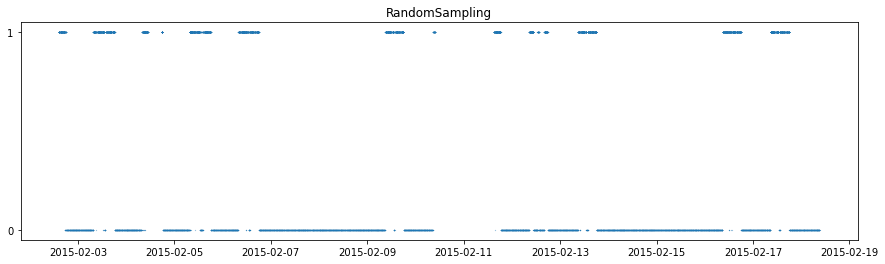

In [91]:
plt.figure(figsize=(15,4))
plt.title('RandomSampling')
plt.scatter(total['date'], total['Occupancy'].astype('str'), s=0.03)
plt.show()

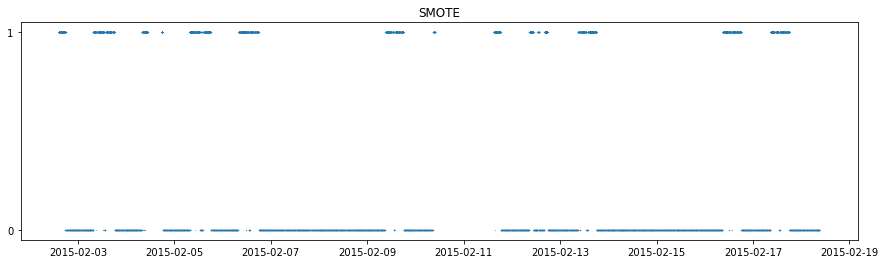

In [92]:
plt.figure(figsize=(15,4))
plt.title('SMOTE')
plt.scatter(SMOTE_total['date'], SMOTE_total['Occupancy'].astype('str'), s=0.03)
plt.show()

In [93]:
## 속도측면, 정확도측면 모델 1개씩 선정 및 이유 제시
## - 분류 : 속도 logistic regression / 정확도 randomforest classifier 선택

In [94]:
## 오버샘플링한 데이터 2개 및 원본 데이터에 대해 모델 2개 적용하고 성능 확인

In [95]:
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

In [96]:
# 불필요 컬럼 제거 

In [97]:
if 'date' in X_train.columns:
    X_train = X_train.drop(columns=['date'])

if 'date' in X_test.columns:
    X_test = X_test.drop(columns=['date'])

In [101]:
result_auc_train = []
result_auc_test = []
result_time = []

for train_X, train_y in [(X_train, y_train), (X_samp, y_samp), (SMOTE_X_samp, SMOTE_y_samp)]:
    
    trainX = train_X.copy()
    testX = X_test.copy()
    sc = MinMaxScaler()
    trainX = sc.fit_transform(trainX)
    testX = sc.transform(testX)
    
    lrstart = time.time()
    lr = LogisticRegression()
    lr.fit(trainX, train_y)
    lrend = time.time() - lrstart
    
    pred_lr = lr.predict(testX)
    auc_lr_train = roc_auc_score(train_y, lr.predict(trainX))
    auc_lr = roc_auc_score(y_test, pred_lr)
    
    rfstart = time.time()
    rf = RandomForestClassifier()
    rf.fit(trainX, train_y)
    rfend = time.time() - rfstart
    
    pred_rf = rf.predict(testX)
    auc_rf_train = roc_auc_score(train_y, rf.predict(trainX))
    auc_rf = roc_auc_score(y_test, pred_rf)
    
    result_auc_test.append([auc_lr, auc_rf])
    result_time.append([lrend, rfend])
    result_auc_train.append([auc_lr_train, auc_rf_train])

In [102]:
# 각 샘플별 lr과 rf 분류의 정확도 및 모델학습시간

print('train set 모델 auc 결과')
result_auc_trains = pd.DataFrame(result_auc_train)
result_auc_trains.index = ['raw','randomSampling','SMOTE']
result_auc_trains.columns = ['logistic','randomforest']
display(result_auc_trains)

print('test set 모델 auc 결과')
result_auc_tests = pd.DataFrame(result_auc_test)
result_auc_tests.index = ['raw','randomSampling','SMOTE']
result_auc_tests.columns = ['logistic','randomforest']
display(result_auc_tests)

print('모델 학습시간 (sec)')
result_times = pd.DataFrame(result_time)
result_times.index = ['raw','randomSampling','SMOTE']
result_times.columns = ['logistic','randomforest']
result_times

훈련셋 모델 auc 결과


,logistic,randomforest
raw,0.985101,1.0
randomSampling,0.988420,1.0
SMOTE,0.989977,1.0


테스트셋 모델 auc 결과


,logistic,randomforest
raw,0.989004,0.988760
randomSampling,0.990598,0.991709
SMOTE,0.990598,0.992347


모델 학습시간 (sec)


,logistic,randomforest
raw,0.025930,0.702154
randomSampling,0.033908,1.390366
SMOTE,0.042885,1.964636


In [103]:
## 오버샘플링이 결과에 미친 영향을 설명
## - lr의 경우, 학습시간은 rf에 비해 짧았지만 (속도 측면에서 lr이 rf보다 유리)
##   정확도는 rf에 비해 낮게 나옴 (test set의 원본 데이터를 적용한 경우만 제외)
## - rf의 경우, train set 학습에서 과적합되었고 (auc 값이 모두 1로 나옴)
##   test set에 대해서는 raw, randomsampling, SMOTE 순서로 auc값이 증가하였음